In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import copy

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=8, width=1.5, direction='in')
        ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=8, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(18) 
####################################### Plotting Function

In [3]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]

In [4]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

In [5]:
def iterator(Clusters, table, ADDkeys, band = 'i', 
            n_iter=5, pgcFaint=[], verbose=False, magCorrection=None,
               addSouth=True, OP_IR=False):
    
    print ADDkeys
    
    for repeat in range(n_iter):

        key0 = 'NEST_100002'   # Virgo base
        myCluster = Clusters[key0]
        zp = myCluster['zp']
        mag = myCluster['mag']-zp
        mag_e = myCluster['mag_e']
        logWimx = myCluster['logWimx']
        logWimx_e = myCluster['logWimx_e']

        for i, key in enumerate(ADDkeys):
            if key!=key0:
                myCluster = Clusters[key]
                zp = myCluster['zp']
                mag = np.concatenate((mag, myCluster['mag']-zp))
                mag_e = np.concatenate((mag_e, myCluster['mag_e']))
                logWimx = np.concatenate((logWimx, myCluster['logWimx']))
                logWimx_e = np.concatenate((logWimx_e, myCluster['logWimx_e']))


        fit, cov = curve_fit(linfit, mag, logWimx-2.5, sigma=np.sqrt(logWimx_e**2+0.01**2))
        m, b = fit
        me = np.sqrt(cov[0,0])
        slope = 1./m
        zp = -b/m   # theoretically zp should equal 0 at this point, since all magnitudes were shifted
        slope_e = np.abs(me/m**2)   

        print slope

        Clusters = allCluster(table, band=band, slope=slope, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)
    
    print '--------------'
    
    return Clusters, slope, zp, slope_e


def NEW_TF_iter(table, key0 = 'NEST_100002', band = 'i', 
            n_iter=5, pgcFaint=[], verbose=False, magCorrection=None,
               addSouth=True, OP_IR=False):
    
    
    Clusters = allCluster(table, band=band, slope=None, pgcFaint=pgcFaint, 
                          magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)
    
    if addSouth==False:
        
        ADDkeys = ['NEST_100008']  # UMa
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)
        
        ADDkeys += ['NEST_200092'] # Pegasus
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)
        
        ADDkeys += ['NEST_200003', 'NEST_200006', 'NEST_200005', 'NEST_100030'] # A262, N507, N410, Cancer
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)    
        
        ADDkeys += ['NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012'] # N80, N70, A1367, Coma, A400, N4065
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)         
        
        ADDkeys += ['NEST_200016'] # A2634/66
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)   
        
        ADDkeys += ['NEST_100007'] # He
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)  
        
    else:
        ADDkeys = ['NEST_100008', 'NEST_200015']  # UMa, Fornax
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)
        
        ADDkeys += ['NEST_200092', 'NEST_100003', 'NEST_100014'] # Pegasus, Centaurus, Antlia
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)
        
        ADDkeys += ['NEST_200003', 'NEST_200006', 'NEST_200005', 'NEST_100030', 'NEST_100006'] # A262, N507, N410, Cancer, Hydra
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)    
        
        ADDkeys += ['NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012'] # N80, N70, A1367, Coma, A400, N4065
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)         
        
        ADDkeys += ['NEST_200016', 'NEST_200017'] # A2634/66, A539
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)   
        
        ADDkeys += ['NEST_100007'] # He
        Clusters, slope, zp, slope_e = iterator(Clusters, table, ADDkeys, n_iter= n_iter, band=band, pgcFaint=pgcFaint, 
                              magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)          
    
    
    return Clusters, slope, zp, slope_e

In [6]:
def NEW_makeTF(table, pgcFaint=[], calib_maglim=[], band='i', makePlot=False, 
                        magCorrection=None, addSouth=True, getZPcalib=False, OP_IR=False):

    Clusters, slope0, zp0, slope_e0 = NEW_TF_iter(table, band=band, pgcFaint=pgcFaint, 
                                magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)

    
    zp_calibs = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim, 
                        magCorrection=magCorrection, OP_IR=OP_IR)
    slope = zp_calibs['slope']
    zp    = zp_calibs['zp']
    zp_e = zp_calibs['zp_e']
    
    Clusters = allCluster(table, band=band, slope=slope, pgcFaint=pgcFaint, 
                        magCorrection=magCorrection, addSouth=addSouth, OP_IR=OP_IR)
    
    if not makePlot:
        return Clusters, np.asarray([slope0, slope_e0, zp, zp_e]), zp_calibs
    else:
        
        fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)

        key0 = 'NEST_100002'
        myCluster = Clusters[key0]
        zp_virgo = myCluster['zp']
        
        N_cluster = 0

        for i, key in enumerate(Clusters):
            
            myCluster = Clusters[key]
            
            pgc =  myCluster['pgc']
            indx = []
            indx_ = []    
            for i, id in enumerate(pgc):
                if not id in pgcFaint:
                    indx.append(i)
                else:
                    indx_.append(i)  
            N_cluster += len(pgc[indx])
            
            if key!=key0:
                zp_ = myCluster['zp']
                plotCluster(ax, Clusters, nest=key, offset=zp_-zp, plotErrors=True, 
                            alpha=0.2, markersize=0, pgcFaint=pgcFaint, plotWeird=True) # cmap(i)
            else:
                plotCluster(ax, Clusters, nest=key, offset=zp_virgo-zp, plotErrors=True, alpha=0.2, 
                            markersize=0, pgcFaint=pgcFaint, plotWeird=True)
        
        ## plotting distance calibrators
        plotCluster(ax, zp_calibs, markersize=8, plotFit=True, color='k', pgcFaint=calib_maglim)
        
        pgc = zp_calibs['pgc']
        indx = []
        indx_ = []    
        for i, id in enumerate(pgc):
            if not id in calib_maglim:
                indx.append(i)
            else:
                indx_.append(i)    
        N_calib = len(pgc[indx])

        ax.text(2.1,-14, "%d" % N_cluster+' Cluster Galaxies', fontsize=12, color='k')
        ax.text(2.1,-13, "%d" % N_calib+' Zeropoint Galaxies', fontsize=12, color='k')
    
        Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
        x0 = 0.95*Xlm[0]+0.05*Xlm[1]
        y0 = 0.1*Ylm[0]+0.90*Ylm[1]
        ax.text(x0,y0, "Slope = "+"%.2f" % slope0+'$\pm$'+"%.2f" % slope_e0, fontsize=12, color='k')
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        ax.text(x0,y0, "ZP = "+"%.2f" % zp+'$\pm$'+"%.2f" % zp_e, fontsize=12, color='k')
        
        if not getZPcalib:
            return fig, ax, Clusters, np.asarray([slope0, slope_e0, zp, zp_e])
        else:
            return fig, ax, Clusters, np.asarray([slope0, slope_e0, zp, zp_e]), zp_calibs

['NEST_100008', 'NEST_200015']
-8.191578922041842
-8.255154969502454
-8.257181204120723
-8.257245864698874
-8.257247952049363
--------------
['NEST_100008', 'NEST_200015', 'NEST_200092', 'NEST_100003', 'NEST_100014']
-8.36525766023186
-8.36961890618548
-8.369797417913432
-8.369804810876778
-8.36980507115132
--------------
['NEST_100008', 'NEST_200015', 'NEST_200092', 'NEST_100003', 'NEST_100014', 'NEST_200003', 'NEST_200006', 'NEST_200005', 'NEST_100030', 'NEST_100006']
-8.244936356468562
-8.227619806988779
-8.225246463702318
-8.224921672181882
-8.224877311386287
--------------
['NEST_100008', 'NEST_200015', 'NEST_200092', 'NEST_100003', 'NEST_100014', 'NEST_200003', 'NEST_200006', 'NEST_200005', 'NEST_100030', 'NEST_100006', 'NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012']
-8.320412463039505
-8.331942032009282
-8.333345735444114
-8.333516748697217
-8.333537459319286
--------------
['NEST_100008', 'NEST_200015', 'NEST_200092', 'NEST_100003', 'NEST_100014', 'NE

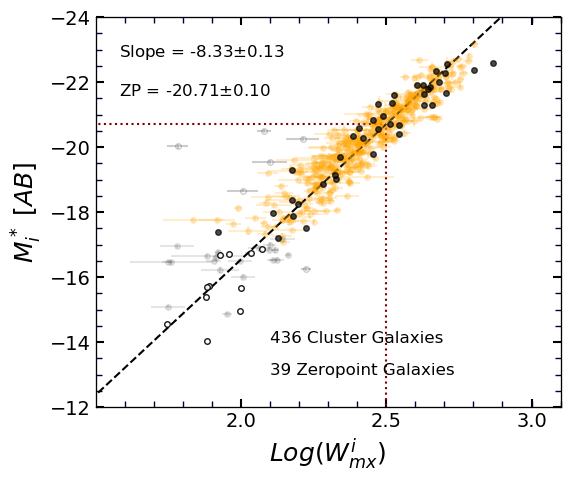

In [7]:
band = 'i'

fig, ax, Clusters, S_ZP, zp_calibs = NEW_makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=True,
                                            getZPcalib=True)